In [1]:
import os
# import drjit
gpu_num = 3 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sionna
import tensorflow as tf
import pickle
import jammer
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')
# tf.config.run_functions_eagerly(True)

from jammer.simulation_model import *
from jammer.utils import *
import jammer.simulation_model as sim
from tensorflow.python.keras.losses import MeanAbsoluteError, MeanSquaredError, BinaryCrossentropy

## Weight Grid

This is the training code and display code for the unmitigated weight grid

In [2]:
# model_parameters = {}
# jammer_parameters = {}
# model_parameters["perfect_csi"] = False
# model_parameters["jammer_present"] = True
# model_parameters["num_silent_pilot_symbols"] = 0
# jammer_parameters["trainable"] = True
# model_parameters["jammer_parameters"] = jammer_parameters
# jammer_parameters["trainable_mask"] = tf.ones([14, 1], dtype=tf.bool)
# 
# sim.BATCH_SIZE = 2
# 
# # massive grid: training with different jammer power and different number of UEs
# num_ut = range(1, 9)
# jammer_power = [db_to_linear(x) for x in np.arange(-2.5, 15.1, 2.5, dtype=np.float32)]
# parameters = [(x, y) for x in num_ut for y in jammer_power]
# n, p = parameters[parameter_num]
# model_parameters["num_ut"] = n
# model_parameters["jammer_power"] = p
# model_parameters["num_ofdm_symbols"] = 14
# model_parameters["fft_size"] = 64
# model_parameters["num_bs_ant"] = 24
# jammer_parameters["trainable_mask"] = tf.ones([14, 1], dtype=tf.bool)
# model = Model(**model_parameters)
# train_model(model,
#             loss_fn=negative_function(MeanAbsoluteError()),
#             loss_over_logits=False,
#             weights_filename=f"weights/unmitigated/grid/ue_{n}_power_{linear_to_db(p):.1f}dB.pickle",
#             log_tensorboard=True,
#             log_weight_images=True,
#             show_final_weights=False,
#             num_iterations=2000,
#             ebno_db=2.5)

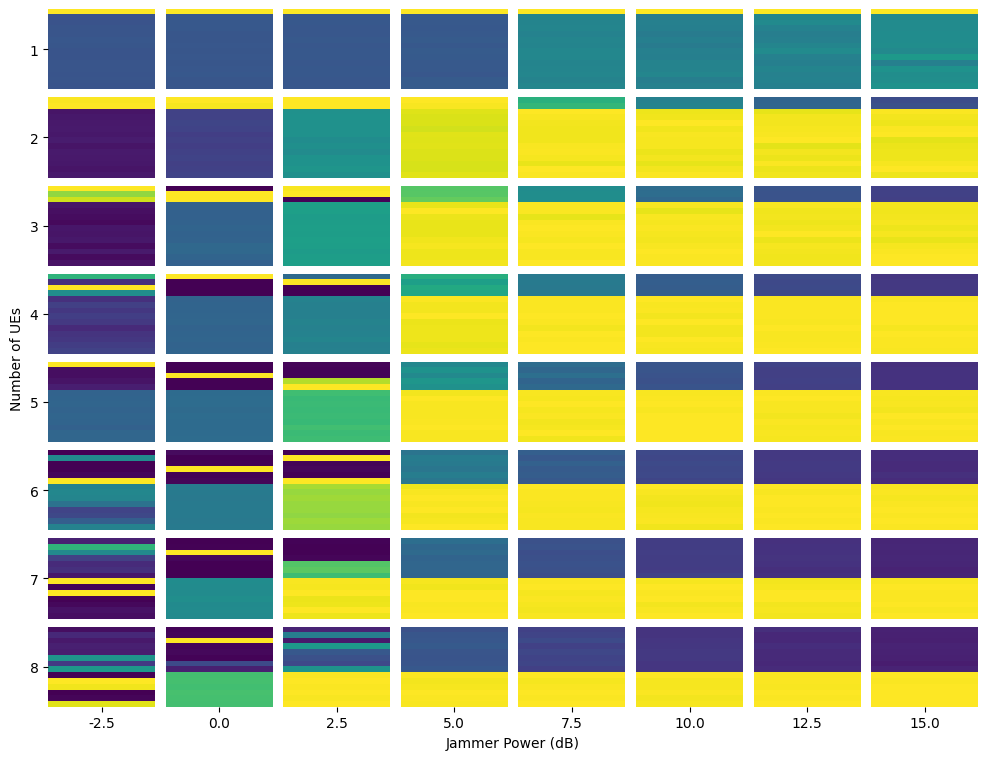

In [4]:
plt.figure(figsize=(10, 7.5))
num_ut = range(1, 9)
jammer_power = np.arange(-2.5, 15.1, 2.5, dtype=np.float32)
bers = np.zeros([len(num_ut), len(jammer_power)])
for i in range(len(num_ut)):
    for j in range(len(jammer_power)):
        n = num_ut[i]
        p = jammer_power[j]
        filename = f"weights/unmitigated/grid/ue_{n}_power_{p}dB.pickle"
        with open(filename, 'rb') as f:
            weights = pickle.load(f)[1]
        weights = MaxMeanSquareNorm()(weights)
        plt.subplot(len(num_ut), len(jammer_power), i * len(jammer_power) + j + 1)
        plt.axis('off')
        # plt.imshow(weights, aspect='auto')
        plt.imshow(np.abs(weights), aspect='auto', vmin=0)

# parameters: space between plots
wspace = 0.1
hspace = 0.1
m = len(num_ut)
n = len(jammer_power)
plt.subplots_adjust(bottom=0.07, top=1.0, left=0.07, right=1.0, wspace=wspace, hspace=hspace)
# labels on the x and y plots-axis
ax = plt.gcf().add_axes([0.07, 0.07, 0.93, 0.93], frameon=False)
plot_width = 1.0 / (n + (n - 1) * wspace)
gap_width = wspace * plot_width
ax.set_xticks(np.arange(plot_width / 2, 1.0, gap_width + plot_width), labels=jammer_power)
ax.set_xlabel("Jammer Power (dB)")
ax.invert_yaxis()
plot_height = 1.0 / (m + (m - 1) * hspace)
gap_height = hspace * plot_height
ax.set_yticks(plot_height / 2 + np.arange(m) * (gap_height + plot_height), labels=num_ut)
ax.set_ylabel("Number of UEs")

plt.show()

## Simple Jammer Result

First demonstration: Unjammed vs Jammed(unmitigated) vs Jammed(POS)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 4.0260e-02 | 1.0000e+00 |     9234661 |   229376000 |       128000 |      128000 |       152.0 |reached max iter       
     -4.0 | 2.0668e-02 | 1.0000e+00 |     4740800 |   229376000 |       128000 |      128000 |       138.7 |reached max iter       
     -3.0 | 9.2766e-03 | 9.9996e-01 |     2127826 |   229376000 |       127995 |      128000 |       138.5 |reached max iter       
     -2.0 | 3.6507e-03 | 9.6346e-01 |      837384 |   229376000 |       123323 |      128000 |       138.3 |reached max iter       
     -1.0 | 1.3007e-03 | 6.2677e-01 |      298354 |   229376000 |        80227 |      128000 |       138.4 |reached max iter       
      0.0 | 4.5352e-04 | 2.6645e-01 |      104026 |   229376000 |        34105 |     

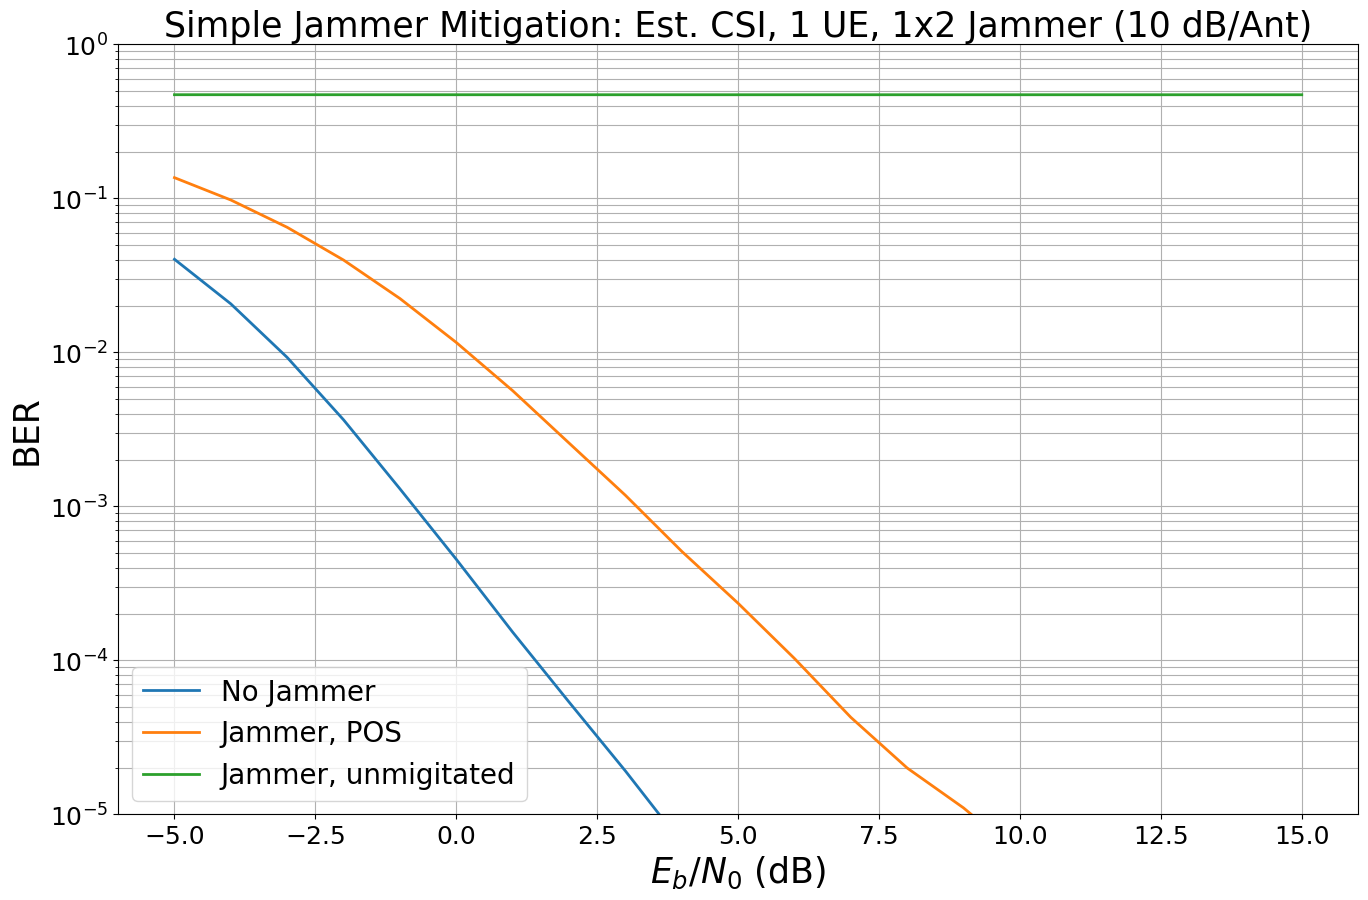

In [2]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["num_ut"] = 1
model_parameters["perfect_csi"] = False
model_parameters["num_silent_pilot_symbols"] = 6
jammer_parameters["num_tx_ant"] = 2
model_parameters["jammer_parameters"] = jammer_parameters
sim.BATCH_SIZE = 256
sim.MAX_MC_ITER = 500
# sim.ebno_dbs = np.linspace(-5., 15., 10)
sim.ebno_dbs = np.linspace(-5., 15., 21)

ber_plots.reset()
model = Model(**model_parameters)
simulate_model(model, "No Jammer")

model_parameters["perfect_jammer_csi"] = False
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(10.)
model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 2
model = Model(**model_parameters)
simulate_model(model, "Jammer, POS")

# model_parameters["jammer_mitigation_dimensionality"] = 1
# model = Model(**model_parameters)
# simulate_model(model, "Jammer, POS, 1D Nulling")

model_parameters["jammer_mitigation"] = None
model = Model(**model_parameters)
simulate_model(model, "Jammer, unmigitated")

ber_plots.title = "Simple Jammer Mitigation: Est. CSI, 1 UE, 1x2 Jammer (10 dB/Ant)"
ber_plots(ylim=(1e-5, 1))
with open("bers/simple_pos.pickle", 'wb') as f:
    bers = pickle.dump(ber_plots, f)

Now we add some velocity (0km/h, 20km/h, 120km/h). Compared with unmitigated jammer.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 4.7147e-01 | 1.0000e+00 |   108142881 |   229376000 |       128000 |      128000 |       157.3 |reached max iter       
     -4.0 | 4.7140e-01 | 1.0000e+00 |   108128220 |   229376000 |       128000 |      128000 |       143.9 |reached max iter       
     -3.0 | 4.7137e-01 | 1.0000e+00 |   108120372 |   229376000 |       128000 |      128000 |       143.1 |reached max iter       
     -2.0 | 4.7131e-01 | 1.0000e+00 |   108106950 |   229376000 |       128000 |      128000 |       143.1 |reached max iter       
     -1.0 | 4.7132e-01 | 1.0000e+00 |   108108864 |   229376000 |       128000 |      128000 |       143.3 |reached max iter       
      0.0 | 4.7123e-01 | 1.0000e+00 |   108089605 |   229376000 |       128000 |     

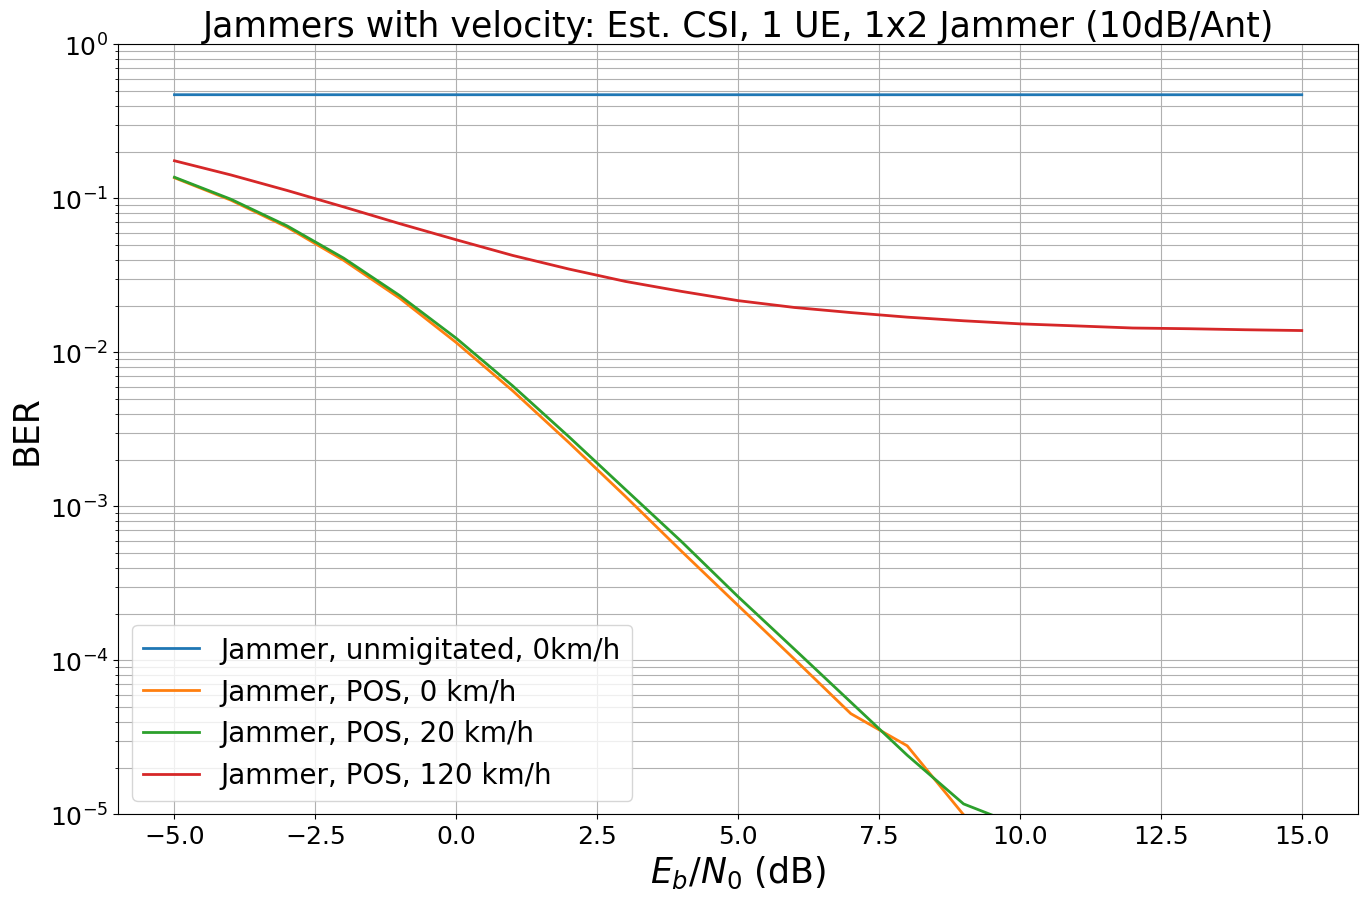

In [3]:
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["num_ut"] = 1
model_parameters["perfect_csi"] = False
model_parameters["perfect_jammer_csi"] = False
model_parameters["num_silent_pilot_symbols"] = 6
jammer_parameters["num_tx_ant"] = 2
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(10.)
sim.BATCH_SIZE = 256
sim.MAX_MC_ITER = 500
sim.ebno_dbs = np.linspace(-5., 15., 21)

model = Model(**model_parameters)
simulate_model(model, "Jammer, unmigitated, 0km/h")

model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 2
kmhs = [0, 20, 120]
for kmh in kmhs:
    meter_per_second = kmh / 3.6
    model_parameters["min_ut_velocity"] = meter_per_second
    model_parameters["max_ut_velocity"] = meter_per_second
    model_parameters["min_jammer_velocity"] = meter_per_second
    model_parameters["max_jammer_velocity"] = meter_per_second
    model = Model(**model_parameters)
    simulate_model(model, f"Jammer, POS, {kmh} km/h")

ber_plots.title = "Jammers with velocity: Est. CSI, 1 UE, 1x2 Jammer (10dB/Ant)"
ber_plots(ylim=(1e-5, 1))
with open("bers/simple_pos_mobility.pickle", 'wb') as f:
    bers = pickle.dump(ber_plots, f)

## Time Domain Simulation

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 6.8782e-02 | 1.0000e+00 |     1267793 |    18432000 |         6000 |        6000 |       494.6 |reached max iter       
     -4.0 | 4.8556e-02 | 1.0000e+00 |      894989 |    18432000 |         6000 |        6000 |       496.4 |reached max iter       
     -3.0 | 3.3200e-02 | 1.0000e+00 |      611937 |    18432000 |         6000 |        6000 |       497.9 |reached max iter       
     -2.0 | 2.1325e-02 | 1.0000e+00 |      393069 |    18432000 |         6000 |        6000 |       497.9 |reached max iter       
     -1.0 | 1.2827e-02 | 1.0000e+00 |      236420 |    18432000 |         6000 |        6000 |       497.5 |reached max iter       
      0.0 | 7.4179e-03 | 1.0000e+00 |      136727 |    18432000 |         6000 |     

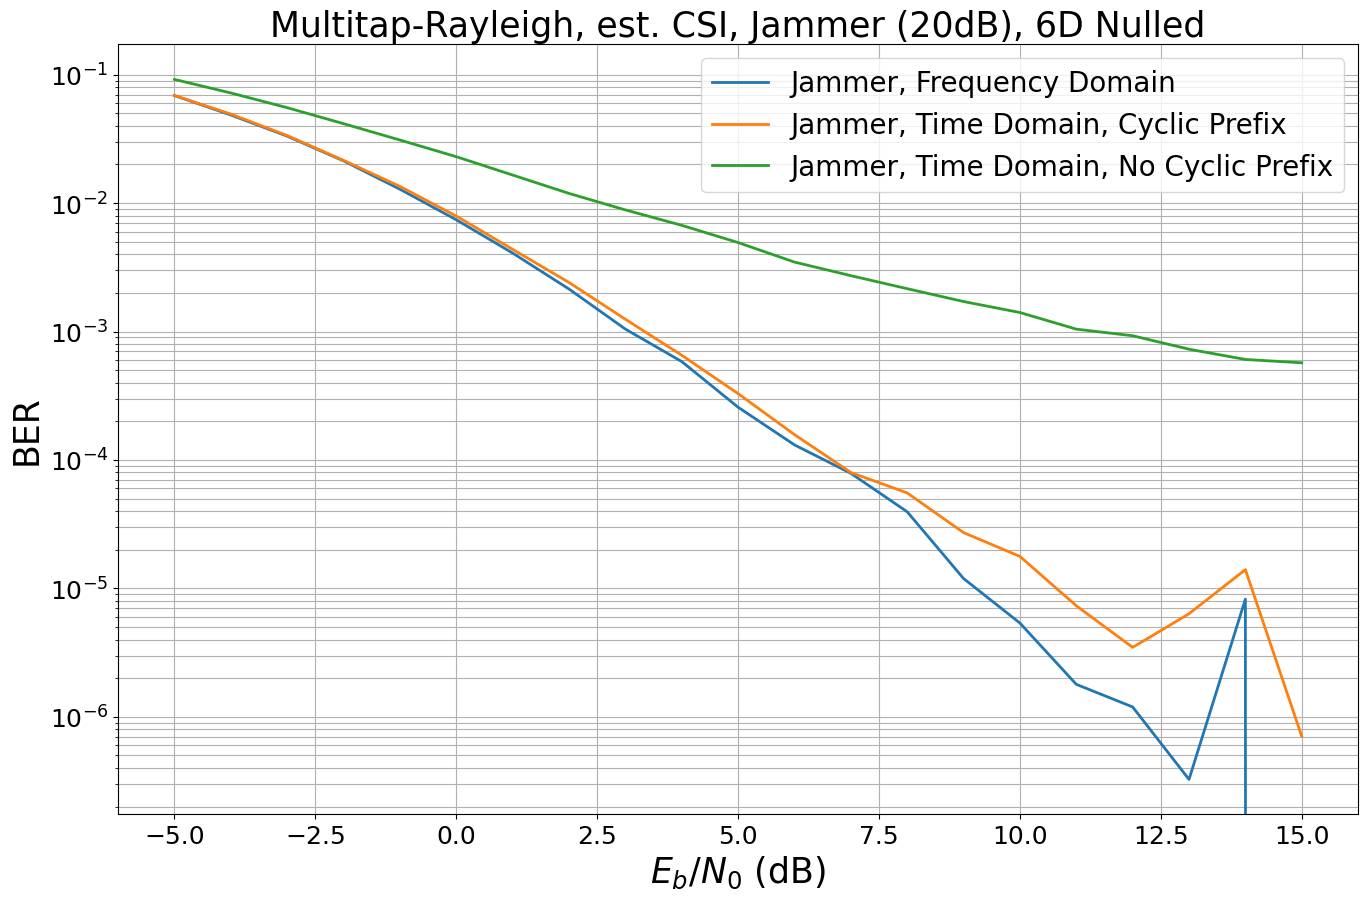

In [3]:
# 1. Multitap-Rayleigh, est. CSI
# 2. UMi, NR-Compliant (2.3us CP), est. CSI
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["num_ut"] = 6
model_parameters["perfect_csi"] = False
model_parameters["perfect_jammer_csi"] = False
model_parameters["num_silent_pilot_symbols"] = 6
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(20.)
model_parameters["jammer_mitigation"] = "ian"
model_parameters["scenario"] = "umi"
model_parameters["cyclic_prefix_length"] = 50
# model_parameters["jammer_mitigation_dimensionality"] = 3
sim.BATCH_SIZE = 4
# sim.MAX_MC_ITER = 70
# sim.ebno_dbs = np.linspace(-5., 15., 10)
sim.MAX_MC_ITER = 1500
sim.ebno_dbs = np.linspace(-5., 15., 21)

model = Model(**model_parameters)
simulate_model(model, "Jammer, Frequency Domain")

model_parameters["domain"] = "time"
jammer_parameters["send_cyclic_prefix"] = True
model = Model(**model_parameters)
simulate_model(model, "Jammer, Time Domain, Cyclic Prefix")

jammer_parameters["send_cyclic_prefix"] = False
model = Model(**model_parameters)
simulate_model(model, "Jammer, Time Domain, No Cyclic Prefix")

ber_plots.title = "Multitap-Rayleigh, est. CSI, Jammer (20dB), 6D Nulled"
ber_plots()
with open("bers/time_pos_rayleigh.pickle", 'wb') as f:
    bers = pickle.dump(ber_plots, f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 6.9586e-03 | 9.9983e-01 |      513043 |    73728000 |        23996 |       24000 |       179.7 |reached max iter       
     -4.0 | 3.6924e-03 | 9.9433e-01 |      272236 |    73728000 |        23864 |       24000 |       158.6 |reached max iter       
     -3.0 | 1.9255e-03 | 9.2921e-01 |      141962 |    73728000 |        22301 |       24000 |       159.3 |reached max iter       
     -2.0 | 9.4210e-04 | 7.3617e-01 |       69459 |    73728000 |        17668 |       24000 |       160.1 |reached max iter       
     -1.0 | 4.4076e-04 | 4.7258e-01 |       32496 |    73728000 |        11342 |       24000 |       161.5 |reached max iter       
      0.0 | 1.9710e-04 | 2.6504e-01 |       14532 |    73728000 |         6361 |     

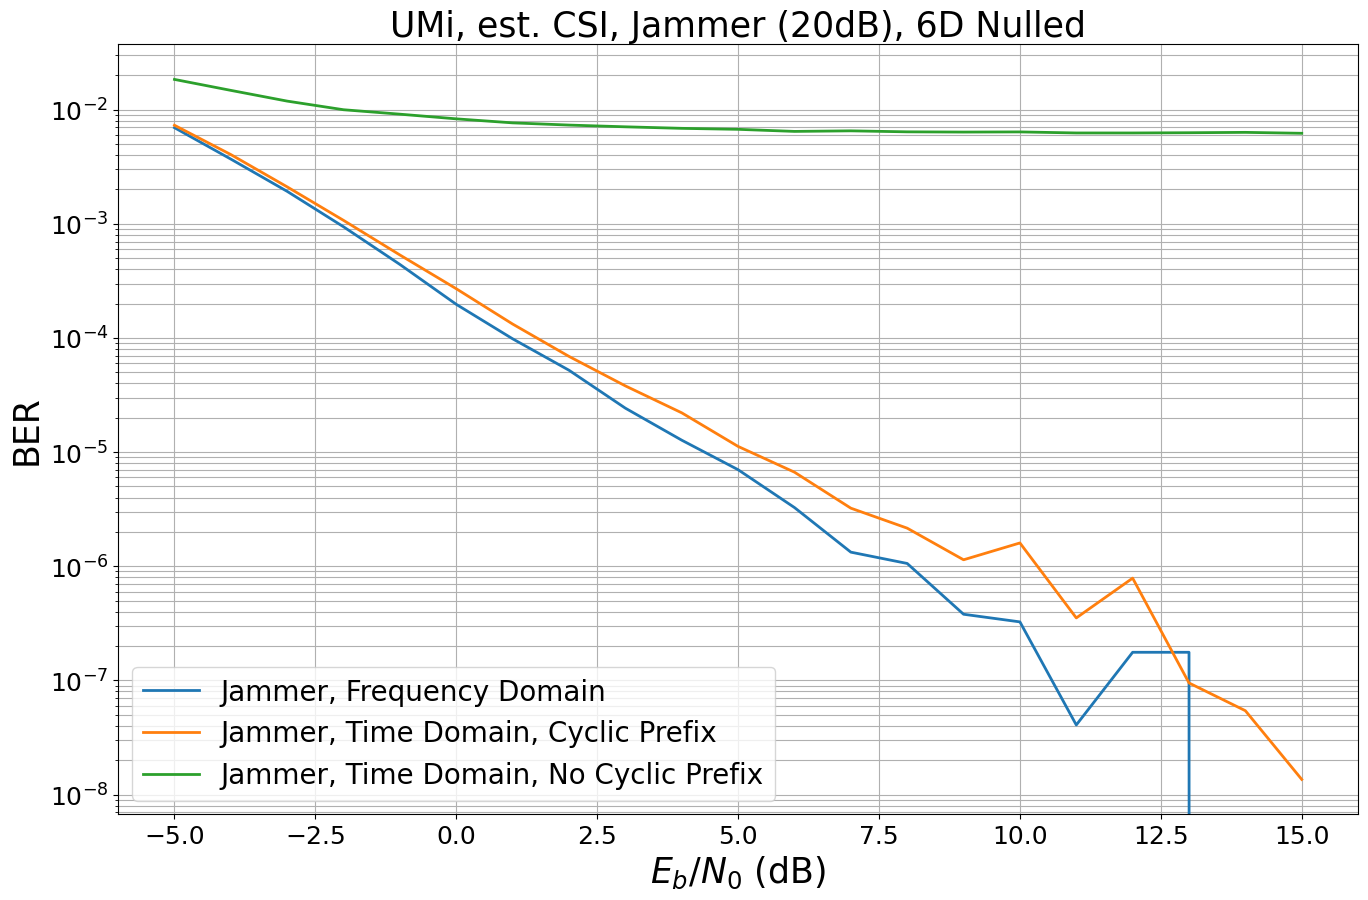

In [2]:
# 1. Multitap-Rayleigh, est. CSI
# 2. UMi, NR-Compliant (2.3us CP), est. CSI
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["num_ut"] = 6
model_parameters["perfect_csi"] = True
model_parameters["perfect_jammer_csi"] = True
model_parameters["num_silent_pilot_symbols"] = 6
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(20.)
model_parameters["jammer_mitigation"] = "ian"
model_parameters["scenario"] = "umi"
model_parameters["cyclic_prefix_length"] = 100
# model_parameters["jammer_mitigation_dimensionality"] = 3
sim.BATCH_SIZE = 8
# sim.MAX_MC_ITER = 70
# sim.ebno_dbs = np.linspace(-5., 15., 10)
sim.MAX_MC_ITER = 3000
sim.ebno_dbs = np.linspace(-5., 15., 21)

model = Model(**model_parameters)
simulate_model(model, "Jammer, Frequency Domain")

model_parameters["domain"] = "time"
jammer_parameters["send_cyclic_prefix"] = True
model = Model(**model_parameters)
simulate_model(model, "Jammer, Time Domain, Cyclic Prefix")

jammer_parameters["send_cyclic_prefix"] = False
model = Model(**model_parameters)
simulate_model(model, "Jammer, Time Domain, No Cyclic Prefix")

ber_plots.title = "UMi, est. CSI, Jammer (20dB), 6D Nulled"
ber_plots()
with open("bers/time_pos_umi.pickle", 'wb') as f:
    bers = pickle.dump(ber_plots, f)

In [3]:
# here real est. CSI
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["num_ut"] = 6
model_parameters["perfect_csi"] = False
model_parameters["perfect_jammer_csi"] = False
model_parameters["num_silent_pilot_symbols"] = 6
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(20.)
model_parameters["jammer_mitigation"] = "ian"
model_parameters["scenario"] = "umi"
model_parameters["cyclic_prefix_length"] = 100
# model_parameters["jammer_mitigation_dimensionality"] = 3
sim.BATCH_SIZE = 8
# sim.MAX_MC_ITER = 70
# sim.ebno_dbs = np.linspace(-5., 15., 10)
sim.MAX_MC_ITER = 3000
sim.ebno_dbs = np.linspace(-5., 15., 21)

model = Model(**model_parameters)
simulate_model(model, "Jammer, Frequency Domain")

model_parameters["domain"] = "time"
jammer_parameters["send_cyclic_prefix"] = True
model = Model(**model_parameters)
simulate_model(model, "Jammer, Time Domain, Cyclic Prefix")

jammer_parameters["send_cyclic_prefix"] = False
model = Model(**model_parameters)
simulate_model(model, "Jammer, Time Domain, No Cyclic Prefix")

ber_plots.title = "UMi @ 20MHz, est. CSI, Jammer (20dB), 6D Nulled"
ber_plots()
with open("bers/time_pos_umi_est.pickle", 'wb') as f:
    bers = pickle.dump(ber_plots, f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 6.8319e-02 | 1.0000e+00 |     5037057 |    73728000 |        24000 |       24000 |       246.3 |reached max iter       
     -4.0 | 4.8538e-02 | 1.0000e+00 |     3578618 |    73728000 |        24000 |       24000 |       230.0 |reached max iter       
     -3.0 | 3.3021e-02 | 1.0000e+00 |     2434545 |    73728000 |        24000 |       24000 |       232.4 |reached max iter       
     -2.0 | 2.1128e-02 | 1.0000e+00 |     1557730 |    73728000 |        24000 |       24000 |       234.7 |reached max iter       
     -1.0 | 1.2911e-02 | 1.0000e+00 |      951915 |    73728000 |        24000 |       24000 |       235.0 |reached max iter       
      0.0 | 7.5087e-03 | 9.9971e-01 |      553602 |    73728000 |        23993 |     

#### Jammer Singular Values

## Coded Jammer Training

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 6.8752e-02 | 9.8000e-01 |      337928 |     4915200 |         1568 |        1600 |       286.0 |reached max iter       
     -4.0 | 4.3471e-02 | 8.9687e-01 |      213671 |     4915200 |         1435 |        1600 |       287.2 |reached max iter       
     -3.0 | 2.9216e-02 | 7.5000e-01 |      143604 |     4915200 |         1200 |        1600 |       287.1 |reached max iter       
     -2.0 | 2.1870e-02 | 6.5500e-01 |      107494 |     4915200 |         1048 |        1600 |       286.9 |reached max iter       
     -1.0 | 1.7775e-02 | 5.8375e-01 |       87369 |     4915200 |          934 |        1600 |       285.0 |reached max iter       
      0.0 | 1.6330e-02 | 5.4875e-01 |       80265 |     4915200 |          878 |     

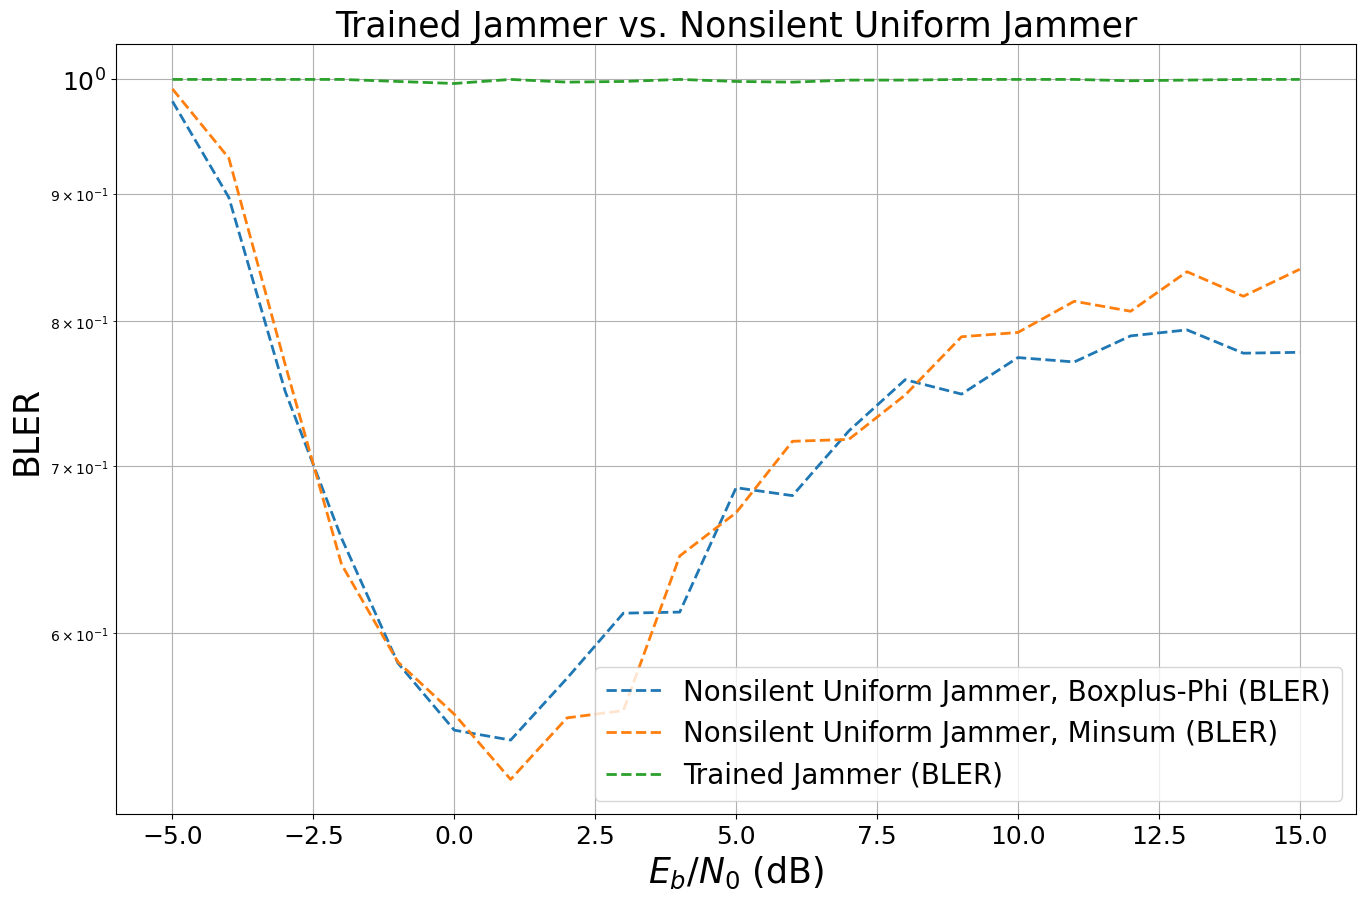

In [5]:
# noch einen Plot mit Minsum
ber_plots.reset()
# common parameters
model_parameters = {}
jammer_parameters = {}
decoder_parameters={}
model_parameters["perfect_csi"] = False
model_parameters["num_ut"] = 4
model_parameters["jammer_present"] = True
model_parameters["jammer_mitigation"] = "pos"
model_parameters["jammer_mitigation_dimensionality"] = 1
model_parameters["num_silent_pilot_symbols"] = 4
model_parameters["coderate"] = 0.5
jammer_parameters["trainable"] = False
jammer_parameters["trainable_mask"] = tf.ones([14, 1], dtype=tf.bool)
decoder_parameters["num_iter"] = 8
decoder_parameters["cn_type"] = "boxplus-phi"
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["decoder_parameters"] = decoder_parameters
# sim.BATCH_SIZE = 128
# sim.MAX_MC_ITER = 50
sim.ebno_dbs = np.linspace(-5., 15., 10)
sim.MAX_MC_ITER = 400
sim.ebno_dbs = np.linspace(-5., 15., 21)

jammer_power = 1.0
model_parameters["jammer_power"] = jammer_power * normalize_power(tf.concat([tf.zeros([4,1]), tf.ones([10,1])], axis=0))

# Nonsilent Uniform jammer
model = Model(**model_parameters)
simulate_model(model, "Nonsilent Uniform Jammer, Boxplus-Phi", add_bler=True)

# Nonsilent Uniform jammer with Minsum
decoder_parameters["cn_type"] = "minsum"
model = Model(**model_parameters)
simulate_model(model, "Nonsilent Uniform Jammer, Minsum", add_bler=True)

# Trained jammer
model_parameters["jammer_power"] = jammer_power
model = Model(**model_parameters)
load_weights(model, "weights/coded/symbol/iteration_loss_2/ue_4_alpha_0.5_exp_False_8_iter.pickle")
simulate_model(model, "Trained Jammer", add_bler=True)

ber_plots.title = "Trained Jammer vs. Nonsilent Uniform Jammer"
ber_plots(show_ber=False)
# with open("bers/coded_bler.pickle", 'wb') as f:
#     bers = pickle.dump(ber_plots, f)

## 

### Channel Filter Taps

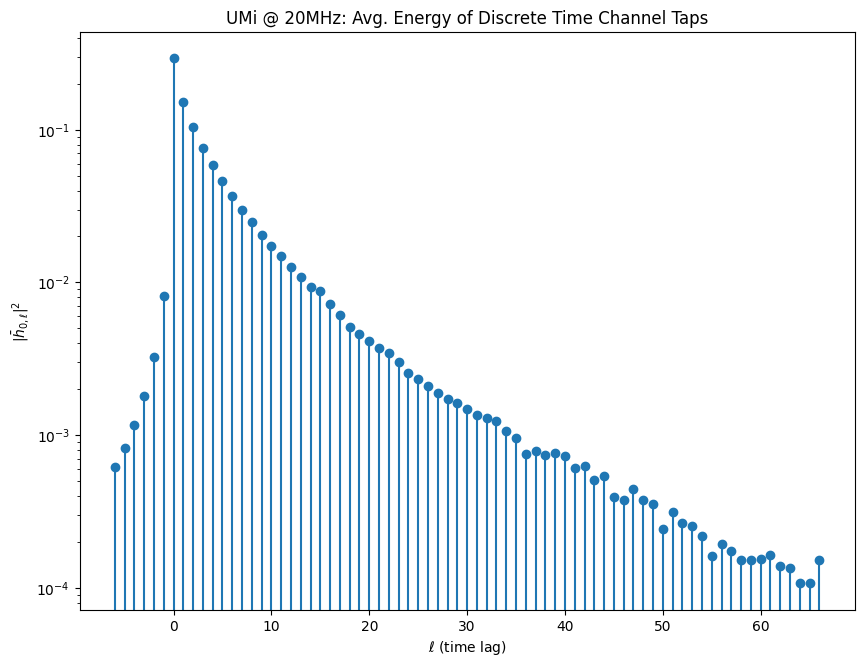

In [5]:
from jammer.channel_visualization import visualize_channel_filter_taps

visualize_channel_filter_taps(scenario='umi', bandwidth=2.e7, resample_topology=True, num_cir_samples=50000)

#### Jammer Interference Singular Values

In [ ]:
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters

model_parameters["domain"] = "time"
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = 316.0
model_parameters["jammer_mitigation"] = "pos"
model_parameters["num_silent_pilot_symbols"] = 50
model_parameters["num_ofdm_symbols"] = 64
model_parameters["return_jammer_signals"] = True
jammer_parameters["num_tx"] = 1
jammer_parameters["num_tx_ant"] = 1

ebno_db = 50.0
BATCH_SIZE = 128
name = "Multiple Jammers"

fig, ax = plt.subplots()
fig.set_size_inches(25, 6)

rel_svs = []
model = Model(**model_parameters)
for i in range(10):
# for i in range(1000):
    if i % 100 == 0:
        print(i, end='\r')
    b, llr, jammer_signals = model(BATCH_SIZE, ebno_db)
    rel_svs.append(relative_singular_values(jammer_signals))
rel_svs = tf.stack(rel_svs)
mean = tf.reduce_mean(rel_svs, axis=0)
std = tf.math.reduce_std(rel_svs, axis=0)

#log scale
# ax.set_yscale("log")
ax.bar(np.arange(len(mean)), mean, 0.2, yerr=2*std)
# axis[scenario].legend(loc="upper right")
plt.show()

#### Smart Jammer Graph

In [5]:
model_parameters = {}
jammer_parameters = {}
model_parameters["perfect_csi"] = False
model_parameters["jammer_present"] = True
model_parameters["jammer_mitigation"] = None
model_parameters["num_silent_pilot_symbols"] = 0
jammer_parameters["trainable"] = True
model_parameters["jammer_parameters"] = jammer_parameters
jammer_parameters["trainable_mask"] = tf.ones([14, 1], dtype=tf.bool)

sim.BATCH_SIZE = 8
sim.MAX_MC_ITER = 250


ber_plots.reset()
jammer_powers_db = [-5, 0, 10]
equivalent_jammer_powers = [-2.5, 1.5, 30.0]
for jammer_power_db, equivalent in zip(jammer_powers_db, equivalent_jammer_powers):
    # barrage simulation
    model = Model(**model_parameters, num_ut=4, jammer_power=db_to_linear(equivalent))
    simulate_model(model, f"Barrage, {equivalent}dB")
    # learned weights
    model = Model(**model_parameters, num_ut=4, jammer_power=db_to_linear(jammer_power_db))
    load_weights(model, f"weights/unmitigated/symbol/ue_4_pow_{jammer_power_db}dB.pickle")
    simulate_model(model, f"Learned, {jammer_power_db}dB")

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 5.4966e-02 | 1.0000e+00 |     1125694 |    20480000 |         2000 |        2000 |        29.2 |reached max iter       
   -3.667 | 3.7916e-02 | 1.0000e+00 |      776527 |    20480000 |         2000 |        2000 |        12.0 |reached max iter       
   -2.333 | 2.6937e-02 | 1.0000e+00 |      551680 |    20480000 |         2000 |        2000 |        12.0 |reached max iter       
     -1.0 | 2.0382e-02 | 1.0000e+00 |      417415 |    20480000 |         2000 |        2000 |        12.3 |reached max iter       
    0.333 | 1.5820e-02 | 1.0000e+00 |      323988 |    20480000 |         2000 |        2000 |        12.1 |reached max iter       
    1.667 | 1.3281e-02 | 1.0000e+00 |      272003 |    20480000 |         2000 |     

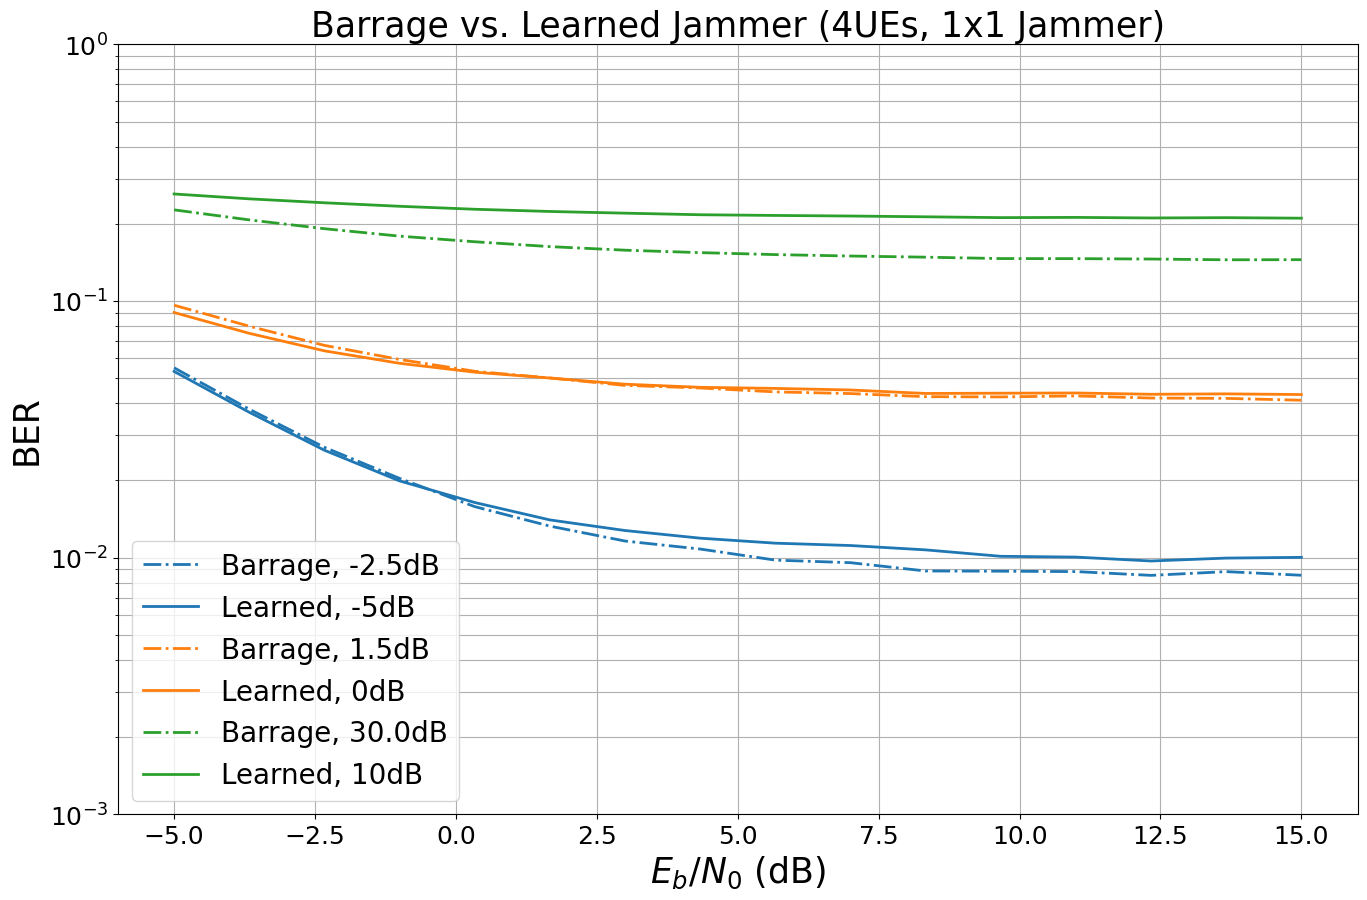

In [44]:
ber_plots.title = "Barrage vs. Learned Jammer (4UEs, 1x1 Jammer)"

from itertools import compress
snrs = list(compress(ber_plots._snrs, np.invert(ber_plots._is_bler)))
bers = list(compress(ber_plots._bers, np.invert(ber_plots._is_bler)))
legends = list(compress(ber_plots._legends, np.invert(ber_plots._is_bler)))
is_bler = list(compress(ber_plots._is_bler, np.invert(ber_plots._is_bler)))

fig, ax = sionna.utils.plot_ber(
    snrs,
    bers,
    legends,
    title = ber_plots.title,
    is_bler = is_bler,
    ylim = (1e-3, 1),
)

colors = plt.get_cmap('tab10').colors
for i, l in enumerate(ax.get_lines()):
    l.set_color(colors[int(i/2)])
    if i%2==0:
        l.set_linestyle('-.')
ax.legend(legends, fontsize=20, loc='lower left')
fig.show()